In [ ]:
!nvcc --version

In [ ]:
# https://pytorch.org/get-started/pytorch-2.0/#faqs
!python -m pip install einops
!python -m pip install gcsfs
!python -m pip install fastparquet
!python -m pip install pynvml
!python -m pip install --pre torch[dynamo] --force-reinstall --extra-index-url https://download.pytorch.org/whl/nightly/cu116

In [1]:
import sys

import os
from pathlib import Path
os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"

import pandas as pd
import numpy as np

#sys.path.append("..")
from otc.models.fttransformer import FTTransformer
from otc.data.dataset import TabDataset
from otc.data.dataloader import TabDataLoader

In [2]:
import wandb

# see https://wandb.ai/fbv/thesis/runs/kwlaw02g/overview?workspace=user-karelze
# for refs

run = wandb.init(project="thesis",entity="fbv")

dataset = "fbv/thesis/ise_log_standardized:v0"
artifact = run.use_artifact(dataset)
data_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact ise_log_standardized:v0, 3813.29MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0


In [3]:
features_classical = [
    "TRADE_PRICE",
    "bid_ex",
    "ask_ex",
    "BEST_ASK",
    "BEST_BID",
    "price_ex_lag",
    "price_ex_lead",
    "price_all_lag",
    "price_all_lead",
    "chg_ex_lead",
    "chg_ex_lag",
    "chg_all_lead",
    "chg_all_lag",
    "prox_ex",
    "prox_best",
]

In [4]:
X_train = pd.read_parquet(Path(data_dir, "train_set_60.parquet"), engine="fastparquet").sample(frac=0.1)

y_train = X_train["buy_sell"]
X_train = X_train[features_classical]

X_val = pd.read_parquet(Path(data_dir, "val_set_20.parquet"), engine="fastparquet").sample(frac=0.1)

y_val = X_val["buy_sell"]
X_val = X_val[features_classical]

In [7]:
from __future__ import annotations

from typing import cast

import numpy.typing as npt
import pandas as pd
import torch
from torch.utils.data import Dataset


class TabDataset(Dataset):
    """PyTorch Dataset for tabular data.

    Args:
        Dataset (Dataset): dataset
    """

    def __init__(
        self,
        x: pd.DataFrame | npt.ndarray,
        y: pd.Series | npt.ndarray,
        weight: pd.Series | npt.ndarray | None = None,
        feature_names: list[str] | None = None,
        cat_features: list[str] | None = None,
        cat_unique_counts: tuple[int, ...] | None = None,
    ):
        """
        Tabular data set holding data for the model.

        Data set is inspired by CatBoost's Pool class:
        https://catboost.ai/en/docs/concepts/python-reference_pool

        Args:
            x (pd.DataFrame | npt.ndarray): feature matrix
            y (pd.Series | npt.ndarray): target
            weight (pd.Series | npt.ndarray | None, optional): weights of samples. If
            not provided all samples are given a weight of 1. Defaults to None.
            feature_names (list[str] | None, optional): list with name of features and
            length of `X.shape[1]`. Needed for npt.ndarrays. Optional for pd.DataFrame.
            If no feature names are provided for pd.DataFrames, names are taken from
            `X.columns`. Defaults to None.
            cat_features (list[str] | None, optional): List with categorical columns.
            Defaults to None.
            cat_unique_counts (tuple[int, ...] | None, optional): Number of categories
            per categorical feature. Defaults to None.
        """
        self._cat_unique_counts = () if not cat_unique_counts else cat_unique_counts
        feature_names = [] if feature_names is None else feature_names
        # infer feature names from dataframe.
        if isinstance(x, pd.DataFrame):
            feature_names = x.columns.tolist()
        # feature_names = cast(list[str], feature_names)
        assert (
            len(feature_names) == x.shape[1]
        ), "`len('feature_names)` must match `X.shape[1]`"

        # calculate cat indices
        cat_features = [] if not cat_features else cat_features
        # cat_features = cast(list[str], cat_features)
        assert set(cat_features).issubset(
            feature_names
        ), "Categorical features must be a subset of feature names."

        self._cat_idx = [
            feature_names.index(i) for i in cat_features if i in feature_names
        ]

        # calculate cont indices
        cont_features = [f for f in feature_names if f not in cat_features]
        self._cont_idx = [
            feature_names.index(i) for i in cont_features if i in feature_names
        ]

        # pd 2 np
        x = x.values if isinstance(x, pd.DataFrame) else x
        y = y.values if isinstance(y, pd.Series) else y
        weight = weight.values if isinstance(weight, pd.Series) else weight

        assert (
            x.shape[0] == y.shape[0]
        ), "Length of feature matrix must match length of target."
        assert len(cat_features) == len(
            self._cat_unique_counts
        ), "For all categorical features the number of unique entries must be provided."

        # adjust target to be either 0 or 1
        self.y = torch.tensor(y).float()
        self.y[self.y < 0] = 0

        # cut into continous and categorical tensor
        self.x_cat: torch.Tensor | None = None
        if len(self._cat_idx) > 0:
            self.x_cat = torch.tensor(x[:, self._cat_idx]).int()
        self.x_cont = torch.tensor(x[:, self._cont_idx]).float()

        # set weights
        weight = (
            torch.tensor(weight).float()
            if weight is not None
            else torch.ones(len(self.y)).float()
        )
        assert (
            y.shape[0] == weight.shape[0]
        ), "Length of label must match length of weight."
        self.weight = weight

    def __len__(self) -> int:
        """
        Length of dataset.

        Returns:
            int: length
        """
        return len(self.x_cont)

    def __getitem__(
        self, idx: int
    ) -> tuple[torch.Tensor | None, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Get sample for model.

        Args:
            idx (int): index of item.

        Returns:
            Tuple[torch.Tensor | None, torch.Tensor, torch.Tensor torch.Tensor]:
            x_cat (if present if present otherwise None), x_cont, weight and y.
        """
        return (
            self.x_cat[idx] if self.x_cat else None,
            self.x_cont[idx],
            self.weight[idx],
            self.y[idx],
        )

In [8]:
"""
A fast dataloader-like object to load batches of tabular data sets.

Adapted from here:
https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
"""
from __future__ import annotations

from typing import Any

import torch


class TabDataLoader:
    """
    PyTorch Implementation of a dataloader for tabular data.

    Due to a chunk-wise reading or several rows at once it is preferred
    over the standard dataloader that reads row-wise.
    """

    def __init__(
        self,
        *tensors: torch.Tensor | None,
        batch_size: int = 4096,
        shuffle: bool = False,
        device: str = "cpu",
        **kwargs: Any,
    ):
        """
        TabDataLoader.

        Tensors can be None e. g., if there is no categorical data.

        Args:
            batch_size (int, optional): size of batch. Defaults to 4096.
            shuffle (bool, optional): shuffle data. Defaults to False.
            device (str, optional): device where. Defaults to "cpu".
        """
        self.device = device
        # check for tensors that are None
        self.none_mask = tuple(t is None for t in tensors)
        # filter if for not none tensors
        self.tensors = tuple(t for t in tensors if t is not None)

        # check if all tensors have same length
        assert all(t.shape[0] == self.tensors[0].shape[0] for t in self.tensors)

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches

    def __iter__(self) -> TabDataLoader:
        """
        Return itself.

        Returns:
            TabDataLoader: TabDataLoader
        """
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = tuple(t[r] for t in self.tensors if t)
        # reset counter on new iteration
        self.i = 0
        return self

    def __next__(self) -> tuple[torch.Tensor | None, ...]:
        """
        Generate next batch with size of 'batch_size'.

        Batches can be underful.
        Raises:
            StopIteration: stopping criterion.
        Returns:
            Tuple[torch.Tensor | None, torch.Tensor, torch.Tensor]: (X_cat), X_cont,
            weight, y
        """
        if self.i >= self.dataset_len:
            raise StopIteration
        mixed_batch: list[torch.Tensor | None] = [
            t[self.i : self.i + self.batch_size].to(self.device) for t in self.tensors
        ]
        self.i += self.batch_size

        # tensors + nones if input tensors contained none
        for i, is_none in enumerate(self.none_mask):
            if is_none:
                mixed_batch.insert(i, None)

        return tuple(mixed_batch)

    def __len__(self) -> int:
        """
        Get number of full and partial batches in data set.

        Returns:
            int: number of batches.
        """
        return self.n_batches


In [9]:
training_data = TabDataset(X_train, y_train)
val_data = TabDataset(X_val, y_val)

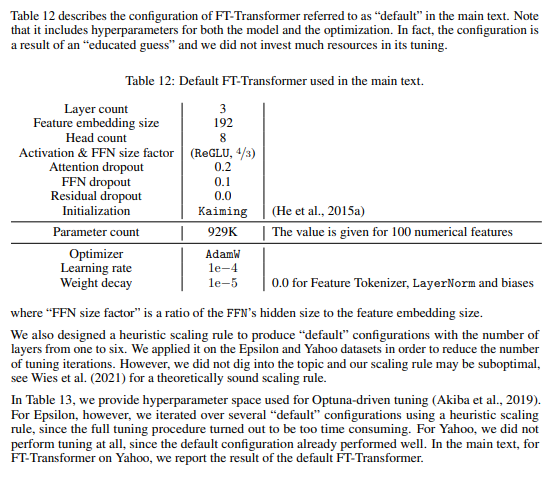

In [29]:
X_train.head()

,TRADE_PRICE,bid_ex,ask_ex,BEST_ASK,BEST_BID,price_ex_lag,price_ex_lead,price_all_lag,price_all_lead,chg_ex_lead,chg_ex_lag,chg_all_lead,chg_all_lag,prox_ex,prox_best
7167710,0.672231,0.705854,0.694579,0.688107,0.693562,0.778892,0.688128,0.706417,0.677273,0.105712,-0.116489,0.005409,-0.032141,-1.111183,-1.019641
11505245,-1.225657,-1.171919,-1.185936,-1.198953,-1.192252,-1.119996,-1.112476,-1.163684,-1.174118,-0.017515,-0.018701,-0.000964,-0.015447,-1.111186,-1.019643
9903122,-1.108932,-1.074832,-1.083239,-1.113920,-1.094749,-0.990813,-0.990324,-1.087761,-1.050990,-0.021365,-0.026524,-0.001495,-0.002092,-0.352347,0.023923
10536941,0.413707,0.427602,0.401567,0.394075,0.414118,0.415734,0.393829,0.285227,0.344219,0.144221,0.090822,0.021342,0.201569,1.165331,1.067489
13517744,-0.995285,-0.985846,-1.005934,-1.018324,-1.005382,-0.899164,-0.717673,-0.942207,-1.007154,-0.106084,-0.018701,0.002753,-0.015447,1.165331,1.067489


In [37]:
X_train.shape

(2951032, 15)

In [30]:
X_val.head()

,TRADE_PRICE,bid_ex,ask_ex,BEST_ASK,BEST_BID,price_ex_lag,price_ex_lead,price_all_lag,price_all_lead,chg_ex_lead,chg_ex_lag,chg_all_lead,chg_all_lag,prox_ex,prox_best
35674537,1.207559,1.072416,1.406691,1.338807,1.061693,1.023546,-0.788720,1.226632,1.229029,3.290358,0.779251,-0.000433,-0.002092,-0.213226,0.002332
32343364,-0.855407,-0.812829,-0.851741,-0.870827,-0.831624,-0.778388,-0.880748,-0.857494,-0.885458,0.047950,-0.010877,0.004347,0.007924,-0.352349,0.023920
32436222,-1.028995,-0.994418,-1.039609,-1.052116,-1.013991,-0.990813,-0.929925,-1.034123,-1.007154,-0.013664,0.008680,0.000629,0.007924,1.165330,1.067488
29555595,1.785985,1.805934,1.801559,1.798940,1.798352,1.205952,1.812843,1.764960,1.905973,0.167325,2.981440,-0.090720,0.211585,-0.974600,-0.894420
36786721,0.088312,0.097629,0.135573,0.097930,0.082733,0.236456,0.209239,0.106436,0.116735,-0.067576,-0.124312,-0.000433,-0.002092,-0.352346,0.023920


In [38]:
X_val.shape

(983185, 15)

In [10]:
from otc.models.fttransformer import FeatureTokenizer, FTTransformer, Transformer

In [25]:
from torch import nn, optim
from otc.models.activation import ReGLU

In [17]:
n_blocks: 3
d_token = 192
attention_dropout = 0.2 
ffn_dropout = 0.1
weight_decay = 1e-5
lr = 1e-4
batch_size = 4096

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
no_devices = torch.cuda.device_count()

In [61]:
feature_tokenizer_kwargs = {
            "num_continous": X_train.shape[1],
            "cat_cardinalities": [],
            "d_token": d_token,
        }

transformer_kwargs = {
            "d_token": d_token,
            "n_blocks": n_blocks,
            "attention_n_heads": 8,
            "attention_initialization": "kaiming",
            "ffn_activation": ReGLU,
            "attention_normalization": nn.LayerNorm,
            "ffn_normalization": nn.LayerNorm,
            "ffn_dropout": ffn_dropout,
            # minor simplification from original paper, fix at 4/3, as activation
            # is static with ReGLU / GeGLU
            "ffn_d_hidden": int(d_token * (4 / 3)),
            "attention_dropout": attention_dropout,
            "residual_dropout": 0.0,
            "prenormalization": True,
            "first_prenormalization": False,
            "last_layer_query_idx": None,
            "n_tokens": None,
            "kv_compression_ratio": None,
            "kv_compression_sharing": None,
            "head_activation": nn.ReLU,
            "head_normalization": nn.LayerNorm,
            "d_out": 1,  # fix at 1, due to binary classification
}

dl_params = {
            "batch_size": batch_size
            * max(no_devices, 1),  # dataprallel splits batches across devices
            "shuffle": False,
            "device": device,
}

module_params = {
            "transformer": Transformer(**transformer_kwargs),  # type: ignore
            "feature_tokenizer": FeatureTokenizer(**feature_tokenizer_kwargs),  # type: ignore # noqa: E501
            "cat_features": [],
            "cat_cardinalities": [],
}

optim_params = {"lr": lr, "weight_decay": weight_decay}

In [49]:
print(optim_params)

{'lr': 0.0001, 'weight_decay': 1e-05}


In [33]:
print(training_data.x_cont)

tensor([[ 6.7223e-01,  7.0585e-01,  6.9458e-01,  ..., -3.2141e-02,
         -1.1112e+00, -1.0196e+00],
        [-1.2257e+00, -1.1719e+00, -1.1859e+00,  ..., -1.5447e-02,
         -1.1112e+00, -1.0196e+00],
        [-1.1089e+00, -1.0748e+00, -1.0832e+00,  ..., -2.0923e-03,
         -3.5235e-01,  2.3923e-02],
        ...,
        [ 1.5379e+00,  1.5537e+00,  1.5356e+00,  ...,  7.0571e-01,
         -1.0952e-01, -1.0131e-01],
        [-1.1755e+00, -9.8585e-01, -9.6527e-01,  ..., -6.5528e-02,
         -4.5260e+00, -4.1503e+00],
        [ 1.9250e-01,  2.3121e-01,  1.9428e-01,  ...,  1.7940e-02,
         -1.1112e+00, -1.0196e+00]])


In [34]:
print(val_data.x_cont)

tensor([[ 1.2076,  1.0724,  1.4067,  ..., -0.0021, -0.2132,  0.0023],
        [-0.8554, -0.8128, -0.8517,  ...,  0.0079, -0.3523,  0.0239],
        [-1.0290, -0.9944, -1.0396,  ...,  0.0079,  1.1653,  1.0675],
        ...,
        [-0.8056, -0.7771, -0.8095,  ..., -0.1256,  0.5962,  0.5457],
        [-0.7381, -0.6960, -0.7425,  ...,  0.0046,  0.0271,  1.0675],
        [ 1.5683,  1.5417,  1.5550,  ..., -2.0187,  1.1653,  1.0675]])


In [ ]:
epochs = 100


# decay weight of very old observations in training set. See eda notebook.
#weight = np.geomspace(0.001, 1, num=len(y))
train_loader = TabDataLoader(training_data.x_cat, training_data.x_cont, training_data.weight, training_data.y, **dl_params
        )
# no weight for validation set / every sample with weight = 1
val_loader = TabDataLoader(val_data.x_cat, val_data.x_cont, val_data.weight, val_data.y, **dl_params)

clf = FTTransformer(**module_params)

# use multiple gpus, if available
clf = clf.to(dl_params["device"])

# half precision, see https://pytorch.org/docs/stable/amp.html
#scaler = torch.cuda.amp.GradScaler()
# Generate the optimizers
optimizer = optim.AdamW(
            clf.parameters(),
            lr=optim_params["lr"],
            weight_decay=optim_params["weight_decay"],
)

# see https://stackoverflow.com/a/53628783/5755604
# no sigmoid required; numerically more stable
# do not reduce, calculate mean after multiplication with weight
criterion = nn.BCEWithLogitsLoss()#(reduction="none")

# keep track of val loss and do early stopping
#early_stopping = EarlyStopping(patience=5)

for epoch in range(epochs):

    # perform training
    loss_in_epoch_train = 0

    clf.train()

    for x_cat, x_cont, weights, targets in train_loader:
        # reset the gradients back to zero
        optimizer.zero_grad()
        #print(x_cont)
        #print(targets)
        #print(logits)
        
        #train_loss = 0
        # compute the model output and train loss
        # with torch.cuda.amp.autocast():
        # print(x_cat)
        # print(x_cont)
        logits = clf(x_cat, x_cont).flatten()
            #intermediate_loss = criterion(logits, targets)
            #train_loss = torch.mean(weights * intermediate_loss)
        train_loss = criterion(logits, targets)

        # print(logits)
        # print(train_loss)
        train_loss.backward()
        optimizer.step()
        # compute accumulated gradients
#         scaler.scale(train_loss).backward()
            
# #         # perform parameter update based on current gradients
#         scaler.step(optimizer)
#         scaler.update()

        # add the mini-batch training loss to epoch loss
        
        loss_in_epoch_train += train_loss.item()

    clf.eval()

    loss_in_epoch_val = 0.0
    correct = 0

    with torch.no_grad():
        for x_cat, x_cont, weights, targets in val_loader:
            logits = clf(x_cat, x_cont)
            logits = logits.flatten()

            # get probabilities and round to nearest integer
            preds = torch.sigmoid(logits).round()
            correct += (preds == targets).sum().item()

            # loss calculation.
            # Criterion contains softmax already.
            # Weight sample loss with weight.
            #intermediate_loss = criterion(logits, targets)
            #val_loss = torch.mean(weights * intermediate_loss)
            val_loss = criterion(logits, targets)

            loss_in_epoch_val += val_loss.item()
    # loss average over all batches
    train_loss = loss_in_epoch_train / len(train_loader)
    val_loss = loss_in_epoch_val / len(val_loader)
    # correct samples / no samples
    val_accuracy = correct / len(X_val)

    print(f"accuracy:{val_accuracy}")
    print(f"train_loss:{train_loss}, val_loss:{val_loss}")
    #self.callbacks.on_epoch_end(epoch, self.epochs, train_loss, val_loss)

    # return early if val accuracy doesn't improve. Minus to minimize.
    # early_stopping(-val_accuracy)
    # if early_stopping.early_stop:
    #     break

accuracy:0.6124818828602959
train_loss:0.5580380016656259, val_loss:0.6970823451691148
accuracy:0.6200633654907266
train_loss:0.5473201159134652, val_loss:0.6932340875206152
accuracy:0.6200918443629633
train_loss:0.5385597609448532, val_loss:0.6944518289625398
accuracy:0.6190503313211654
train_loss:0.530042001096617, val_loss:0.692265259774394
accuracy:0.620946210530063
train_loss:0.5246898842337393, val_loss:0.6908032693803557
accuracy:0.6189577749863963
train_loss:0.5208149457275454, val_loss:0.6915219277761784


In [5]:
# import os
# os._exit(00)

In [ ]:
from __future__ import annotations

import pandas as pd
import torch
from torch.utils.data import Dataset


class TabDataset(Dataset):
    """PyTorch Dataset for tabular data.
    Args:
        Dataset (Dataset): dataset
    """

    def __init__(
        self,
        x: pd.DataFrame,
        y: pd.Series,
        cat_features: list[str] | None = None,
        cat_unique_counts: tuple[int, ...] | None = None,
    ):
        """
        Tabular data set holding data for the model.
        Args:
            x (pd.DataFrame): feature matrix.
            y (pd.Series): target.
            cat_features (Optional[List[str]], optional): List with categorical columns.
            Defaults to None.
            cat_unique_counts (Optional[Tuple[int]], optional): Number of categories per
            categorical feature. Defaults to None.
        """
        self._cat_unique_counts = () if not cat_unique_counts else cat_unique_counts

        # calculate cat indices
        features = x.columns.tolist()
        cat_features = [] if not cat_features else cat_features
        self._cat_idx = [features.index(i) for i in cat_features if i in features]

        # calculate cont indices
        cont_features = [f for f in features if f not in cat_features]
        self._cont_idx = [features.index(i) for i in cont_features if i in features]

        assert (
            x.shape[0] == y.shape[0]
        ), "Length of feature matrix must match length of target."
        assert len(cat_features) == len(
            self._cat_unique_counts
        ), "For all categorical features the number of unique entries must be provided."

        # adjust target to be either 0 or 1
        self.y = torch.tensor(y.values).float()
        self.y[self.y < 0] = 0

        # cut into continous and categorical tensor
        self.x_cat: torch.Tensor | None = None
        if len(self._cat_idx) > 0:
            self.x_cat = torch.tensor(x.iloc[:, self._cat_idx].values).int()
        self.x_cont = torch.tensor(x.iloc[:, self._cont_idx].values).float()

    def __len__(self) -> int:
        """
        Length of dataset.
        Returns:
            int: length
        """
        return len(self.x_cont)

    def __getitem__(
        self, idx: int
    ) -> tuple[torch.Tensor | None, torch.Tensor, torch.Tensor]:
        """
        Get sample for model.
        Args:
            idx (int): _description_
        Returns:
            Tuple[torch.Tensor | None, torch.Tensor, torch.Tensor]:
            x_cat (if present if present otherwise None), x_cont and y.
        """
        return (
            self.x_cat[idx] if self.x_cat else None,
            self.x_cont[idx],
            self.y[idx],
        )


In [ ]:
"""
A fast dataloader-like object to load batches of tabular data sets.
Adapted from here:
https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
"""
from __future__ import annotations

from typing import Any

import torch


class TabDataLoader:
    """
    PyTorch Implementation of a dataloader for tabular data.
    Due to a chunk-wise reading or several rows at once it is preferred
    over the standard dataloader that reads row-wise.
    """

    def __init__(
        self,
        *tensors: torch.Tensor | None,
        batch_size: int = 4096,
        shuffle: bool = False,
        device: str = "cpu",
        **kwargs: Any,
    ):
        """
        TabDataLoader.
        Tensors can be None e. g., if there is no categorical data.
        Args:
            batch_size (int, optional): size of batch. Defaults to 4096.
            shuffle (bool, optional): shuffle data. Defaults to False.
            device (str, optional): device where. Defaults to "cpu".
        """
        self.device = device
        # check for tensors that are None
        self.none_mask = tuple(t is None for t in tensors)
        # filter if for not none tensors
        self.tensors = tuple(t for t in tensors if t is not None)

        # check if all tensors have same length
        assert all(t.shape[0] == self.tensors[0].shape[0] for t in self.tensors)

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches

    def __iter__(self) -> TabDataLoader:
        """
        Return itself.
        Returns:
            TabDataLoader: TabDataLoader
        """
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = tuple(t[r] for t in self.tensors if t)
        # reset counter on new iteration
        self.i = 0
        return self

    def __next__(self) -> tuple[torch.Tensor | None, ...]:
        """
        Generate next batch with size of 'batch_size'.
        Batches can be underful.
        Raises:
            StopIteration: stopping criterion.
        Returns:
            Tuple[torch.Tensor | None, torch.Tensor, torch.Tensor]: (X_cat), X_cont, y
        """
        if self.i >= self.dataset_len:
            raise StopIteration
        mixed_batch: list[torch.Tensor | None] = [
            t[self.i : self.i + self.batch_size].to(self.device) for t in self.tensors
        ]
        self.i += self.batch_size

        # tensors + nones if input tensors contained none
        for i, is_none in enumerate(self.none_mask):
            if is_none:
                mixed_batch.insert(i, None)

        return tuple(mixed_batch)

    def __len__(self) -> int:
        """
        Get number of full and partial batches in data set.
        Returns:
            int: number of batches.
        """
        return self.n_batches


In [ ]:
class Residual(nn.Module):
    """
    PyTorch implementation of residual connections.
    Args:
        nn (nn.Module): module
    """

    def __init__(self, fn: nn.Module):
        """
        Residual connection.
        Args:
            fn (nn.Module): network.
        """
        super().__init__()
        self.fn = fn

    def forward(self, x: torch.Tensor, **kwargs: Any) -> torch.Tensor:
        """
        Forward pass of residual connections.
        Args:
            x (torch.Tensor): input tensor.
        Returns:
            torch.Tensor: output tensor.
        """
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    """
    PyTorch implementation of pre-normalization.
    Args:
        nn (nn.module): module.
    """

    def __init__(self, dim: int, fn: nn.Module):
        """
        Pre-normalization.
        Consists of layer for layer normalization followed by another network.
        Args:
            dim (int): Number of dimensions of normalized shape.
            fn (nn.Module): network.
        """
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x: torch.Tensor, **kwargs: Any) -> torch.Tensor:
        """
        Forward pass of pre-normalization layers.
        Args:
            x (torch.Tensor): input tensor.
        Returns:
            torch.Tensor: output tensor.
        """
        return self.fn(self.norm(x), **kwargs)


class GEGLU(nn.Module):
    r"""
    Implementation of the GeGLU activation function.
    Given by:
    $\operatorname{GeGLU}(x, W, V, b, c)=\operatorname{GELU}(x W+b) \otimes(x V+c)$
    Proposed in https://arxiv.org/pdf/2002.05202v1.pdf.
    Args:
        nn (torch.Tensor): module
    """

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of GeGlU activation.
        Args:
            x (torch.Tensor): input tensor.
        Returns:
            torch.Tensor: output tensor.
        """
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)


class FeedForward(nn.Module):
    """
    PyTorch implementation of feed forward network.
    Args:
        nn (nn.module): module.
    """

    def __init__(self, dim: int, mult: int = 4, dropout: float = 0.0):
        """
        Feed forward network.
        Network consists of input layer, GEGLU activation, dropout layer,
        and output layer.
        Args:
            dim (int): dimension of input and output layer.
            mult (int, optional): Scaling factor for output dimension of input layer or
            input dimension of output layer. Defaults to 4.
            dropout (float, optional): Degree of dropout. Defaults to 0.0.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim),
        )

    def forward(self, x: torch.Tensor, **kwargs: Any) -> torch.Tensor:
        """
        Forward pass of feed forward network.
        Args:
            x (torch.Tensor): input tensor.
        Returns:
            torch.Tensor: output tensor.
        """
        return self.net(x)


class Attention(nn.Module):
    """
    Pytorch implementation of attention.
    Args:
        nn (nn.Module): module.
    """

    def __init__(
        self, dim: int, heads: int = 8, dim_head: int = 16, dropout: float = 0.0
    ):
        """
        Attention.
        Args:
            dim (int): Number of dimensions.
            heads (int, optional): Number of attention heads. Defaults to 8.
            dim_head (int, optional): Dimension of attention heads. Defaults to 16.
            dropout (float, optional): Degree of dropout. Defaults to 0.0.
        """
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head**-0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of attention module.
        Args:
            x (torch.Tensor): input tensor.
        Returns:
            torch.Tensor: output tensor.
        """
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=h), (q, k, v))
        sim = einsum("b h i d, b h j d -> b h i j", q, k) * self.scale

        attn = sim.softmax(dim=-1)
        attn = self.dropout(attn)

        out = einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)", h=h)
        return self.to_out(out)


class Transformer(nn.Module):
    """
    Transformer.
    Based on paper:
    https://arxiv.org/abs/1706.03762
    Args:
        nn (nn.Module): Module with transformer.
    """

    def __init__(
        self,
        num_tokens: int,
        dim: int,
        depth: int,
        heads: int,
        dim_head: int,
        attn_dropout: float,
        ff_dropout: float,
    ):
        """
        Classical transformer.
        Args:
            num_tokens (int): Number of tokens i. e., unique classes + special tokens.
            dim (int): Number of dimensions.
            depth (int): Depth of encoder / decoder.
            heads (int): Number of attention heads.
            dim_head (int): Dimensions of attention heads.
            attn_dropout (float): Degree of dropout in attention.
            ff_dropout (float): Degree of dropout in feed-forward network.
        """
        super().__init__()
        self.embeds = nn.Embedding(num_tokens, dim)  # (Embed the categorical features.)
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        Residual(
                            PreNorm(
                                dim,
                                Attention(
                                    dim,
                                    heads=heads,
                                    dim_head=dim_head,
                                    dropout=attn_dropout,
                                ),
                            )
                        ),
                        Residual(PreNorm(dim, FeedForward(dim, dropout=ff_dropout))),
                    ]
                )
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of transformer.
        Args:
            x (torch.Tensor): input tensor.
        Returns:
            torch.Tensor: output tensor.
        """
        x = self.embeds(x)

        for attn, ff in self.layers:  # type: ignore
            x = attn(x)
            x = ff(x)

        return x


class MLP(nn.Module):
    """
    Pytorch model of a vanilla multi-layer perceptron.
    Args:
        nn (nn.Module): module with implementation of MLP.
    """

    def __init__(self, dims: List[int], act: Union[str, Callable[..., nn.Module]]):
        """
        Multilayer perceptron.
        Depth of network is given by `len(dims)`. Capacity is given by entries
        of `dim`. Activation function is used after each linear layer. There is
        no activation function for the final linear layer, as it is sometimes part
        of the loss function already e. g., `nn.BCEWithLogitsLoss()`.
        Args:
            dims (List[int]): List with dimensions of layers.
            act (Union[str, Callable[..., nn.Module]]): Activation function of each linear layer.
        """
        super().__init__()
        dims_pairs = list(zip(dims[:-1], dims[1:]))
        layers = []
        for dim_in, dim_out in dims_pairs:
            linear = nn.Linear(dim_in, dim_out)
            layers.append(linear)
            layers.append(act)

        # drop last layer, as a sigmoid layer is included from BCELogitLoss
        del layers[-1]

        self.mlp = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward propagate tensor through MLP.
        Args:
            x (torch.Tensor): input tensor.
        Returns:
            torch.Tensor: output tensor.
        """
        return self.mlp(x)


class TabTransformer(nn.Module):
    """
    PyTorch model of TabTransformer.
    Based on paper:
    https://arxiv.org/abs/2012.06678
    Args:
        nn (nn.Module): Module with implementation of TabTransformer.
    """

    def __init__(
        self,
        *,
        categories: Union[List[int], Tuple[()]],
        num_continuous: int,
        dim: int = 32,
        depth: int = 4,
        heads: int = 8,
        dim_head: int = 16,
        dim_out: int = 1,
        mlp_hidden_mults: Tuple[(int, int)] = (4, 2),
        mlp_act: Union[str, Callable[..., nn.Module]] = nn.ReLU,
        num_special_tokens: int = 2,
        continuous_mean_std: Optional[torch.Tensor] = None,
        attn_dropout: float = 0.0,
        ff_dropout: float = 0.0,
    ):
        """
        TabTransformer.
        Originally introduced in https://arxiv.org/abs/2012.06678.
        Args:
            categories (Union[List[int],Tuple[()]]): List with number of categories
            for each categorical feature. If no categorical variables are present,
            use empty tuple. For categorical variables e. g., option type ('C' or 'P'),
            the list would be `[1]`.
            num_continuous (int): Number of continous features.
            dim (int, optional): Dimensionality of transformer. Defaults to 32.
            depth (int, optional): Depth of encoder / decoder of transformer.
            Defaults to 4.
            heads (int, optional): Number of attention heads. Defaults to 8.
            dim_head (int, optional): Dimensionality of attention head. Defaults to 16.
            dim_out (int, optional): Dimension of output layer of MLP. Set to one for
            binary classification. Defaults to 1.
            mlp_hidden_mults (Tuple[(int, int)], optional): multipliers for dimensions
            of hidden layer in MLP. Defaults to (4, 2).
            mlp_act (Union[str, Callable[..., nn.Module]], optional): Activation function used in MLP.
            Defaults to nn.ReLU().
            num_special_tokens (int, optional): Number of special tokens in transformer.
            Defaults to 2.
            continuous_mean_std (Optional[torch.Tensor]): List with mean and
            std deviation of each continous feature. Shape eq. `[num_continous x 2]`.
            Defaults to None.
            attn_dropout (float, optional): Degree of attention dropout used in
            transformer. Defaults to 0.0.
            ff_dropout (float, optional): Dropout in feed forward net. Defaults to 0.0.
        """
        super().__init__()
        assert all(
            map(lambda n: n > 0, categories)
        ), "number of each category must be positive"

        # categories related calculations

        self.num_categories = len(categories)
        self.num_unique_categories = sum(categories)

        # create category embeddings table

        self.num_special_tokens = num_special_tokens
        total_tokens = self.num_unique_categories + num_special_tokens

        # for automatically offsetting unique category ids to the correct position
        #  in the categories embedding table

        categories_offset = F.pad(
            torch.tensor(list(categories)), (1, 0), value=num_special_tokens
        )  # Prepend num_special_tokens.
        categories_offset = categories_offset.cumsum(dim=-1)[:-1]
        self.register_buffer("categories_offset", categories_offset)

        # continuous

        if continuous_mean_std is not None:
            assert continuous_mean_std.shape == (num_continuous, 2,), (
                f"continuous_mean_std must have a shape of ({num_continuous}, 2)"
                f"where the last dimension contains the mean and variance respectively"
            )
        self.register_buffer("continuous_mean_std", continuous_mean_std)

        self.norm = nn.LayerNorm(num_continuous)
        self.num_continuous = num_continuous

        # transformer

        self.transformer = Transformer(
            num_tokens=total_tokens,
            dim=dim,
            depth=depth,
            heads=heads,
            dim_head=dim_head,
            attn_dropout=attn_dropout,
            ff_dropout=ff_dropout,
        )

        # mlp to logits

        input_size = (dim * self.num_categories) + num_continuous
        j = input_size // 8

        hidden_dimensions = list(map(lambda t: j * t, mlp_hidden_mults))
        all_dimensions = [input_size, *hidden_dimensions, dim_out]

        self.mlp = MLP(all_dimensions, act=mlp_act)

    def forward(self, x_categ: torch.Tensor, x_cont: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of TabTransformer.
        Args:
            x_categ (torch.Tensor): tensor with categorical data.
            x_cont (torch.Tensor): tensor with continous data.
        Returns:
            torch.Tensor: predictions with shape [batch, 1]
        """
        # Adaptation to work without categorical data
        if x_categ is not None:
            assert x_categ.shape[-1] == self.num_categories, (
                f"you must pass in {self.num_categories} "
                f"values for your categories input"
            )
            x_categ += self.categories_offset
            x = self.transformer(x_categ)
            flat_categ = x.flatten(1)

        assert x_cont.shape[1] == self.num_continuous, (
            f"you must pass in {self.num_continuous} "
            f"values for your continuous input"
        )

        if self.continuous_mean_std is not None:
            mean, std = self.continuous_mean_std.unbind(dim=-1)
            x_cont = (x_cont - mean) / std

        normed_cont = self.norm(x_cont)

        # Adaptation to work without categorical data
        if x_categ is not None:
            x = torch.cat((flat_categ, normed_cont), dim=-1)
        else:
            x = normed_cont

        return self.mlp(x)


In [ ]:
# https://svn.blender.org/svnroot/bf-blender/trunk/blender/build_files/scons/tools/bcolors.py
# https://stackoverflow.com/a/287944/5755604
class colors:
    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"
    ENDC = "\033[0m"
    OKCYAN = "\033[96m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

    def disable(self):
        self.HEADER = ""
        self.OKBLUE = ""
        self.OKGREEN = ""
        self.OKCYAN = ""
        self.WARNING = ""
        self.FAIL = ""
        self.ENDC = ""
        self.BOLD = ""
        self.UNDERLINE = ""


In [ ]:
columns = [
    "TRADE_SIZE",
    "TRADE_PRICE",
    "BEST_ASK",
    "BEST_BID",
    "price_ex_lag",
    "price_ex_lead",
    "price_all_lag",
    "price_all_lead",
    "bid_ex",
    "ask_ex",
    "bid_size_ex",
    "ask_size_ex",
    "OPTION_TYPE",
    "buy_sell",
]


X = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_20.parquet",
    engine="fastparquet",
    columns=columns,
)


In [ ]:
X.head()


In [ ]:
# select categorical e. g., option type and strings e. g., ticker
cat_columns = X.select_dtypes(include=["category", "object"]).columns.tolist()

# binarize categorical similar to Borisov et al.
X[cat_columns] = X[cat_columns].apply(lambda x: pd.factorize(x)[0])

X.fillna(-1, inplace=True)


In [ ]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

x_train = X.head(100000)
y_train = x_train["buy_sell"]
x_train.drop(columns=["buy_sell"], inplace=True)

x_val = X.tail(50000)
y_val = x_val["buy_sell"]
x_val.drop(columns=["buy_sell"], inplace=True)

features = x_train.columns.tolist()
cat_features = ["OPTION_TYPE"]

_cat_unique = [2]
if not _cat_unique:
    _cat_unique = ()
# assume columns are duplicate free, which is standard in pandas
cont_features = [x for x in x_train.columns.tolist() if x not in cat_features]

# print(cat_features)

# static params
epochs = 8


#  use gpu if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"cuda_available: {device}")
print(f"num of cores:{os.cpu_count()}")


# create training and val set
training_data = TabDataset(x_train, y_train, cat_features, _cat_unique)
val_data = TabDataset(x_val, y_val, cat_features, _cat_unique)

dim: int = 64  # type: ignore

depth: int = 3
heads: int = 8
weight_decay: float = 1e-5
lr = 4e-3
dropout = 0.2
batch_size: int = 8192

# span as many workers as cores
dl_kwargs = (
    {
        "num_workers": os.cpu_count(),
        "pin_memory": True,
        "batch_size": batch_size,
        "shuffle": False,
    }
    if use_cuda
    else {"batch_size": batch_size, "shuffle": False}
)


train_loader = TabDataLoader(
    training_data.x_cat, training_data.x_cont, training_data.y, **dl_kwargs
)
val_loader = TabDataLoader(val_data.x_cat, val_data.x_cont, val_data.y, **dl_kwargs)


_clf = TabTransformer(
    categories=_cat_unique,
    num_continuous=len(cont_features),  # number of continuous values
    dim_out=1,
    mlp_act=nn.ReLU(),  # sigmoid of last layer already included in loss.
    dim=dim,
    depth=depth,
    heads=heads,
    attn_dropout=dropout,
    ff_dropout=dropout,
    mlp_hidden_mults=(4, 2),
).to(device)

# # API NOT FINAL
# # default: optimizes for large models, low compile-time
# #          and no extra memory usage
# torch.compile(model)

# # reduce-overhead: optimizes to reduce the framework overhead
# #                and uses some extra memory. Helps speed up small models
# torch.compile(model, mode="reduce-overhead")

# max-autotune: optimizes to produce the fastest model,
#               but takes a very long time to compile
# _clf = torch.compile(_clf, mode="max-autotune")


# prof = torch.profiler.profile(
#         schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
#         on_trace_ready=torch.profiler.tensorboard_trace_handler('./drive/MyDrive/log/tabtransformer'),
#         record_shapes=True,
#         with_stack=True)
# prof.start()


scaler = torch.cuda.amp.GradScaler()

# Generate the optimizers
optimizer = optim.AdamW(_clf.parameters(), lr=lr, weight_decay=weight_decay)

# see https://stackoverflow.com/a/53628783/5755604
# no sigmoid required; numerically more stable
criterion = nn.BCEWithLogitsLoss()


def our() -> None:

    for epoch in range(epochs):

        # perform training
        loss_in_epoch_train = 0

        _clf.train()

        for x_cat, x_cont, targets in train_loader:

            x_cat = x_cat.to(device)
            x_cont = x_cont.to(device)
            targets = targets.to(device)
            # print(x_cat.is_cuda)

            # reset the gradients back to zero
            optimizer.zero_grad()

            outputs = _clf(x_cat, x_cont)
            outputs = outputs.flatten()

            with torch.cuda.amp.autocast():
                train_loss = criterion(outputs, targets)

            # compute accumulated gradients
            scaler.scale(train_loss).backward()

            # perform parameter update based on current gradients
            scaler.step(optimizer)
            scaler.update()

            # add the mini-batch training loss to epoch loss
            loss_in_epoch_train += train_loss.item()

        #     prof.step()
        # prof.stop()

        _clf.eval()

        loss_in_epoch_val = 0.0

        with torch.no_grad():
            for x_cat, x_cont, targets in val_loader:
                x_cat = x_cat.to(device)
                x_cont = x_cont.to(device)
                targets = targets.to(device)

                outputs = _clf(x_cat, x_cont)

                outputs = outputs.flatten()

                val_loss = criterion(outputs, targets)
                loss_in_epoch_val += val_loss.item()

        train_loss = loss_in_epoch_train / len(train_loader)
        val_loss = loss_in_epoch_val / len(val_loader)


## Data pipes

In [ ]:
!pip install torchdata

In [ ]:
import torchdata.datapipes.iter as pipes
from itertools import islice


In [ ]:
from torchdata.datapipes.iter import IterableWrapper

dp = IterableWrapper(range(10))
dp = dp.batch(batch_size=3, drop_last=True)
list(dp)


In [ ]:
from torchdata.dataloader2.adapter import PinMemory


In [ ]:
from torchdata.datapipes.iter import IterableWrapper
import torcharrow.dtypes as dt

source_data = [(i,) for i in range(3)]
source_dp = IterableWrapper(source_data)
DTYPE = dt.Struct([dt.Field("Values", dt.int32)])
df_dp = source_dp.dataframe(dtype=DTYPE)
list(df_dp)[0]


In [ ]:
datapipe = pipes.IterableWrapper(training_data).batch(batch_size=4)

it = iter(datapipe)
list(islice(it, 2))


* https://pytorch.org/data/main/dataloader2.html (pin memory has not been implemented yet)
* https://pytorch.org/data/main/generated/torchdata.datapipes.iter.DataFrameMaker.html (would likely not be able to handle 'None')
* https://pytorch.org/data/main/generated/torchdata.datapipes.iter.ParquetDataFrameLoader.html#torchdata.datapipes.iter.ParquetDataFrameLoader

## Comparsion

In [ ]:
# warm up
our()

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
our()

torch.cuda.synchronize()  # wait for all_reduce to complete
end.record()

torch.cuda.synchronize()  # need to wait once more for op to finish

our_time = start.elapsed_time(end)

print(f"our: {our_time :>5.1f} ms")  # milliseconds


In [ ]:
x_train = X.head(100000)
y_train = x_train["buy_sell"]
x_train.drop(columns=["buy_sell"], inplace=True)

x_val = X.tail(50000)
y_val = x_val["buy_sell"]
x_val.drop(columns=["buy_sell"], inplace=True)

features = x_train.columns.tolist()
cat_features = ["OPTION_TYPE"]


_cat_idx = [features.index(i) for i in cat_features if i in features]

# assume columns are duplicate free, which is standard in pandas
cont_features = [x for x in x_train.columns.tolist() if x not in cat_features]
_cont_idx = [features.index(i) for i in cont_features if i in features]

_cat_unique = [2]
if not _cat_unique:
    _cat_unique = ()
# assume columns are duplicate free, which is standard in pandas
cont_features = [x for x in x_train.columns.tolist() if x not in cat_features]

print(cat_features)

# static params
epochs = 8

# FIXME: fix embedding lookup for ROOT / Symbol.
# convert to tensor
x_train = tensor(x_train.values).float()
# FIXME: Integrate at another part of the code e. g., pre-processing / data set.
x_train = torch.nan_to_num(x_train, nan=0)

y_train = tensor(y_train.values).float()
# FIXME: set -1 to 0, due to rounding before output + binary classification
y_train[y_train < 0] = 0

x_val = tensor(x_val.values).float()
x_val = torch.nan_to_num(x_val, nan=0)
y_val = tensor(y_val.values).float()
y_val[y_val < 0] = 0

# create training and val set
training_data = TensorDataset(x_train, y_train)
val_data = TensorDataset(x_val, y_val)

dim: int = 64  # type: ignore

depth: int = 3
heads: int = 8
weight_decay: float = 1e-5
lr = 4e-3
dropout = 0.2
batch_size: int = 1024


train_loader = DataLoader(
    training_data, batch_size=batch_size, shuffle=False, num_workers=2
)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_clf = TabTransformer(
    categories=_cat_unique,
    num_continuous=len(_cont_idx),  # number of continuous values
    dim_out=1,
    mlp_act=nn.ReLU(),  # sigmoid of last layer already included in loss.
    dim=dim,
    depth=depth,
    heads=heads,
    attn_dropout=dropout,
    ff_dropout=dropout,
    mlp_hidden_mults=(4, 2),
).to(device)

# Generate the optimizers
optimizer = optim.AdamW(_clf.parameters(), lr=lr, weight_decay=weight_decay)

# see https://stackoverflow.com/a/53628783/5755604
# no sigmoid required; numerically more stable
criterion = nn.BCEWithLogitsLoss()


def their() -> None:

    for epoch in range(epochs):

        # perform training
        loss_in_epoch_train = 0

        _clf.train()

        for inputs, targets in train_loader:

            # FIXME: refactor to custom data loader
            x_cat = inputs[:, _cat_idx].int().to(device) if _cat_idx else None

            x_cont = inputs[:, _cont_idx].to(device)
            targets = targets.to(device)

            # reset the gradients back to zero
            optimizer.zero_grad()

            outputs = _clf(x_cat, x_cont)
            outputs = outputs.flatten()

            train_loss = criterion(outputs, targets)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            loss_in_epoch_train += train_loss.item()

        _clf.eval()

        loss_in_epoch_val = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:

                x_cat = inputs[:, _cat_idx].int().to(device) if _cat_idx else None
                x_cont = inputs[:, _cont_idx].to(device)
                targets = targets.to(device)

                outputs = _clf(x_cat, x_cont)

                outputs = outputs.flatten()

                val_loss = criterion(outputs, targets)
                loss_in_epoch_val += val_loss.item()

        train_loss = loss_in_epoch_train / len(train_loader)
        val_loss = loss_in_epoch_val / len(val_loader)


In [ ]:
# warm up
their()

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
their()

torch.cuda.synchronize()  # wait for all_reduce to complete
end.record()

torch.cuda.synchronize()  # need to wait once more for op to finish

their_time = start.elapsed_time(end)
print(f"our: {their_time :>5.1f} ms")  # milliseconds
print(f"speedup: {their_time / our_time}")
